#### From : https://github.com/TuSimple/tusimple-benchmark/blob/master/example/lane_demo.ipynb
Create road lane semantic segmentation dataset from tuSimple dataset

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import glob
import os
import random

In [3]:
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec

In [4]:
import torch
from torch.utils import data

### tuSimple dataset

In [5]:
train_path = '/data/tuSimple/train_set/'
test_path = '/data/tuSimple/test_set/'
json_0313_path = '/data/tuSimple/train_set/label_data_0313.json'
json_0531_path = '/data/tuSimple/train_set/label_data_0531.json'
json_0601_path = '/data/tuSimple/train_set/label_data_0601.json'

In [6]:
json_lists = glob.glob(os.path.join(train_path, "*.json"))

In [7]:
train_json = []
for json_list in json_lists:
    train_json += [json.loads(line) for line in open(json_list)]

In [8]:
lanes = [lane['lanes'] for lane in train_json]
y_samples = [y_sample['h_samples'] for y_sample in train_json]
raw_files = [raw_file['raw_file'] for raw_file in train_json]

In [9]:
raw_files[0]

'clips/0313-1/6040/20.jpg'

In [10]:
lane_pts = [[(x,y) for (x,y) in zip(lane, y_samples[0]) if x >= 0] for lane in lanes[0]]

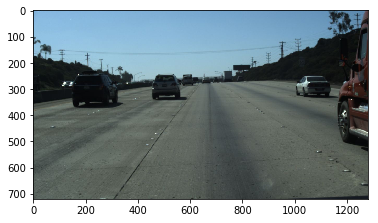

In [11]:
img = plt.imread(os.path.join(train_path, raw_files[0]))
plt.imshow(img)

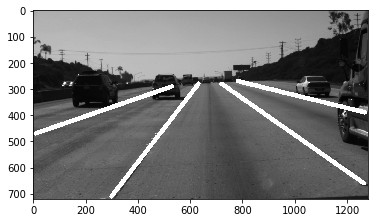

In [12]:
img_label = img.copy()
for i, lane_pt in enumerate(lane_pts):
    cv2.polylines(img_label, np.int32([lane_pt]), isClosed=False, color=(255,255,255), thickness=15)
    
img_label = cv2.cvtColor(img_label, cv2.COLOR_RGB2GRAY)
plt.imshow(img_label, 'gray')

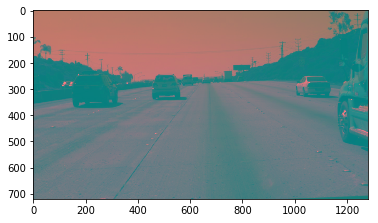

In [13]:
img = cv2.imread(os.path.join(train_path, raw_files[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
plt.imshow(img)

In [14]:
img.shape

(720, 1280, 3)

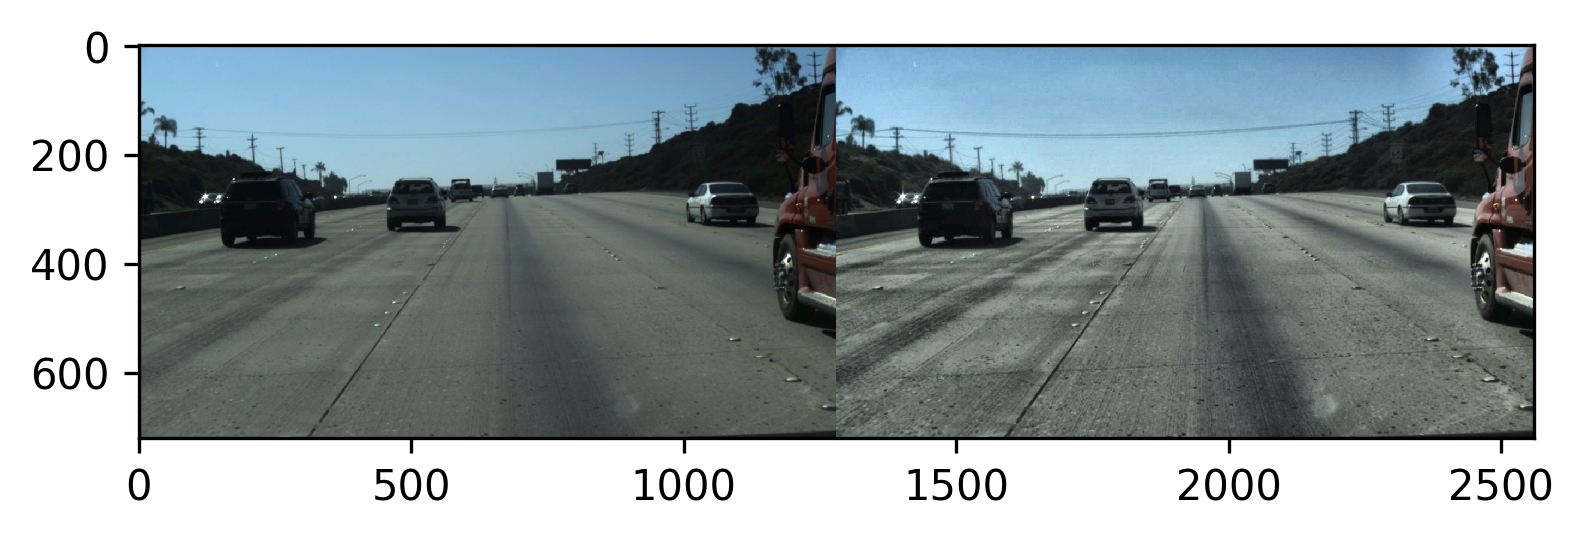

In [15]:
img_plane = cv2.split(img)
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_plane[0] = clahe.apply(img_plane[0])
img1 = cv2.merge(img_plane)
img1 = np.hstack((img, img1))
img1 = cv2.cvtColor(img1, cv2.COLOR_LAB2RGB)

plt.figure(dpi=300)
plt.imshow(img1)

#### Pytorch Dataset

In [16]:
import torch
from torch.utils import data
from torchvision import transforms
from torchvision.utils import make_grid

In [17]:
from skimage.transform import AffineTransform, warp

In [18]:
class tuSimpleDataset(data.Dataset):
    # refer from : 
    # https://github.com/vxy10/ImageAugmentation
    # https://github.com/TuSimple/tusimple-benchmark/blob/master/example/lane_demo.ipynb
    def __init__(self, file_path, size=[640, 360], gray=True, trans=True, intensity=10):
        self.file_path = file_path
        self.flags = {'size':size, 'gray':gray, 'transform':trans, 'intensity':intensity}
        self.json_lists = glob.glob(os.path.join(self.file_path, '*.json'))
        self.labels = []
        for json_list in self.json_lists:
            self.labels += [json.loads(line) for line in open(json_list)]
        self.lanes = [lane['lanes'] for lane in self.labels]
        self.y_samples = [y_sample['h_samples'] for y_sample in self.labels]
        self.raw_files = [raw_file['raw_file'] for raw_file in self.labels]
        self.img = np.zeros(size, np.uint8)
        self.label_img = np.zeros(size, np.uint8)
        
        self.len = len(self.labels)
        
        
    def warp_affine(self, M):
        self.img = cv2.warpAffine(self.img, M, tuple(self.flags['size']))
        self.label_img = cv2.warpAffine(self.label_img, M, tuple(self.flags['size']))
        
    def random_brightness(self):
        img = cv2.cvtColor(self.img, cv2.COLOR_RGB2HSV)
        rand_bright = .15 + np.random.uniform()
        img[:,:,2] = img[:,:,2]*rand_bright
        self.img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
        
    def random_rotate(self, ang_range=20):
        ang_rot = np.random.uniform(ang_range) - ang_range/2
        Rot_M = cv2.getRotationMatrix2D((self.flags['size'][1]/2, self.flags['size'][0]/2), ang_rot, 1)
        self.warp_affine(Rot_M)
        
    def random_translate(self, trans_range=10):
        tr_x = trans_range * np.random.uniform() - trans_range/2
        tr_y = trans_range * np.random.uniform() - trans_range/2
        Trans_M = np.float32([[1, 0, tr_x],[0, 1, tr_y]])
        self.warp_affine(Trans_M)
        
    def random_shear(self, shear_range=5):
        pts1 = np.float32([[5,5],[20,5],[5,20]])
        pt1 = 5+shear_range*np.random.uniform()-shear_range/2
        pt2 = 20+shear_range*np.random.uniform()-shear_range/2
        pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])
        Shear_M = cv2.getAffineTransform(pts1, pts2)
        self.warp_affine(Shear_M)
        
    def random_transform(self):
        intensity=self.flags['intensity']
        def _get_delta(intensity):
            delta = np.radians(intensity)
            rand_delta = np.random.uniform(low=-delta, high=delta)
            return rand_delta
        trans_M = AffineTransform(scale=(.9, .9),
                                 translation=(-_get_delta(intensity), _get_delta(intensity)),
                                 shear=_get_delta(intensity))
        self.img = warp(self.img, trans_M)
        self.label_img = warp(self.label_img, trans_M)
    
    def image_resize(self):
        self.img = cv2.resize(self.img, tuple(self.flags['size']), interpolation=cv2.INTER_CUBIC)
        self.label_img = cv2.resize(self.label_img, tuple(self.flags['size']), interpolation=cv2.INTER_CUBIC)
    
    def preprocess(self):
        # CLAHE nomalization
        img = cv2.cvtColor(self.img, cv2.COLOR_RGB2LAB)
        img_plane = cv2.split(img)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
        img_plane[0] = clahe.apply(img_plane[0])
        img = cv2.merge(img_plane)
        self.img = cv2.cvtColor(img, cv2.COLOR_LAB2RGB)
   
    def get_lane_image(self, idx):
        lane_pts = [[(x,y) for (x,y) in zip(lane, self.y_samples[idx]) if x >= 0] for lane in self.lanes[idx]]
        self.img = plt.imread(os.path.join(self.file_path, self.raw_files[idx]))
        self.label_img = np.zeros_like(self.img)
        
        for lane_pt in lane_pts:
            cv2.polylines(self.label_img, np.int32([lane_pt]), isClosed=False, color=(255,255,255), thickness=15)   
            
        if self.flags['gray']:
            self.label_img = cv2.cvtColor(self.label_img, cv2.COLOR_BGR2GRAY)

    def __getitem__(self, idx):
        self.get_lane_image(idx)
        self.image_resize()
        self.preprocess()
#         self.random_brightness()
#         self.random_rotate()
#         self.random_translate()
#         self.random_shear()

        self.random_transform()
        self.img = np.array(np.transpose(self.img, (2,0,1)), dtype=np.float32)
        self.label_img = np.array(self.label_img, dtype=np.uint8)
        return torch.FloatTensor(self.img), torch.LongTensor(self.label_img)
    
    def __len__(self):
        return self.len


In [19]:
D = tuSimpleDataset(train_path, size=[1280, 720])

rand_idx = random.randint(0, D.len)
transformed_img, transformed_label = D.__getitem__(rand_idx)
print(np.shape(transformed_img), np.shape(transformed_label))

img = np.transpose(transformed_img.cpu().numpy(), (1,2,0))
label = transformed_label.cpu().numpy()
# label = np.dstack([label, label, label])

print(img.shape, label.shape)



torch.Size([3, 720, 1280]) torch.Size([720, 1280])
(720, 1280, 3) (720, 1280)


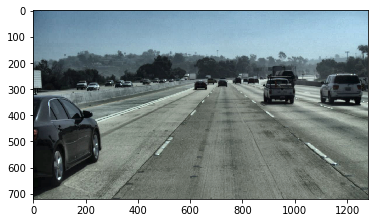

In [20]:
plt.imshow(img)

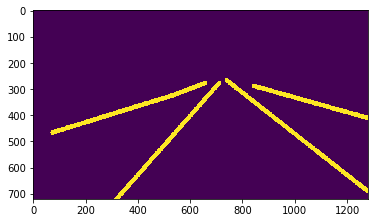

In [21]:
plt.imshow(label)

In [22]:
assert(False)

AssertionError: 

### BDD-dataset

In [ ]:
train_path = '/data/bdd-data/bdd100k/images/100k/train/'
test_path = '/data/bdd-data/bdd100k/images/100k/test/'
val_path = '/data/bdd-data/bdd100k/images/100k/val/'

In [ ]:
train_label_path = '/data/bdd-data/bdd100k/labels/100k/train/'
val_label_path = '/data/bdd-data/bdd100k/labels/100k/val/'

In [ ]:
img_lists = sorted(glob.glob(train_path + '*.jpg'))

In [ ]:
img_lists[10]

In [ ]:
plt.imshow(plt.imread(img_lists[10]))

In [ ]:
json_train_lists = sorted(glob.glob(train_label_path + '*.json'))

In [ ]:
json_train_lists[10]

In [ ]:
labels = [json.load(open(json_train_list)) for json_train_list in json_train_lists]

In [ ]:
len(labels)

In [ ]:
objects = labels[10]['frames'][0]['objects']

In [ ]:
def get_lanes(objects):
    return [o for o in objects
           if 'poly2d' in o and o['category'][:4] == 'lane']

In [ ]:
lanes = get_lanes(objects)
lanes

In [ ]:
pts = []
for lane in lanes:
    pts.append([p[:2] for p in lane['poly2d']])

In [ ]:
pts

In [ ]:
img = plt.imread(img_lists[10])

In [ ]:
for i,pt in enumerate(pts):
    cv2.polylines(img, np.int32([pt]), isClosed=False, color=(0,255, 0),thickness=5)
plt.imshow(img)